<a href="https://colab.research.google.com/github/repoocsov/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [145]:
df = df.drop('diagnosis', axis=1)
df = df.drop('Unnamed: 32', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
# Breast Cancer dataframe = df
# M = malignant, B = benign
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Using seaborns pairplot two look at relationships that look to have clustering
#sns.pairplot(df)

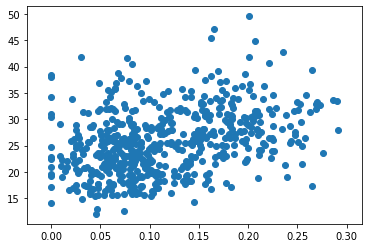

In [147]:
# All of the scatterplots look to have a singular clustering
# df['concave points_worst'] & df['texture_worst']

# Using the elbow method to decide on the number of clusters to use

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

two_columns = {'x': df['concave points_worst'], 'y': df['texture_worst']}
subset_df = pd.DataFrame(data=two_columns)
subset_df

# Create scatterplot with coloring based on assigned labels
fig, ax = plt.subplots()

plt.scatter(x=subset_df['x'], y=subset_df['y'])
plt.show()       

In [148]:
# Calculate the centroid of the entire dataset (only for demonstration purposes)
dataset_centroid_x = subset_df['x'].mean()
dataset_centroid_y = subset_df['y'].mean()

print(dataset_centroid_x, dataset_centroid_y)

0.11460622319859404 25.677223198594014


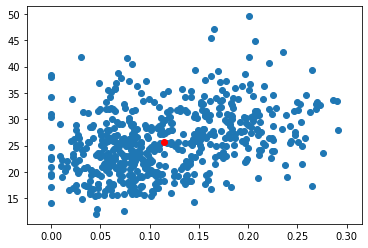

In [149]:
ax.plot(subset_df['x'], subset_df['y'])
ax = plt.subplot(1,1,1)
ax.scatter(subset_df['x'], subset_df['y'])
ax.plot(dataset_centroid_x, dataset_centroid_y, "or")
plt.show()

In [0]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(subset_df)
    sum_of_squared_distances.append(km.inertia_)

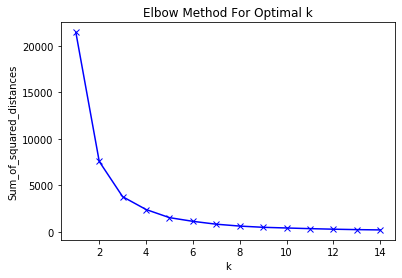

In [151]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [155]:
# Looks like around 2-3 is the optimal number of K (over 90%)
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=2)
kmeans.fit(subset_df)
labels = kmeans.labels_

print(labels)

[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1
 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0
 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0
 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 

In [158]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
subset_df['clusters'] = new_series.values

subset_df.head(20)

,x,y,clusters
0,0.26540,17.33,0
1,0.18600,23.41,0
2,0.24300,25.53,0
3,0.25750,26.50,0
4,0.16250,16.67,0
5,0.17410,23.75,0
6,0.19320,27.66,1
7,0.15560,28.14,1
8,0.20600,30.73,1
9,0.22100,40.68,1


In [0]:
"""RYAN'S FUNCTIONS"""
import math
import numpy as np
from scipy.spatial import distance

# Calculate the Nearest Centroid to each data point
def find_nearest_centroid(df, centroids, iteration):
 
  # calculate the distances between each point and each centroid
  distances = distance.cdist(df, centroids, 'euclidean')
  
  # Get nearest centroid to each point based on distance
  nearest_centroids = np.argmin(distances, axis=1)

  se = pd.Series(nearest_centroids)
  df['cluster_'+iteration] = se.values
  
  return df

def get_centroids(df, column_header):
  new_centroids = df.groupby(column_header).mean()
  return new_centroids

def plot_clusters(df, column_header, centroids):
  colors = {0:'red', 1:'green'}
  fig, ax = plt.subplots()
  ax.plot(centroids.iloc[0].x, centroids.iloc[0].y, "ok")
  ax.plot(centroids.iloc[1].x, centroids.iloc[1].y, "ok")


  grouped = df.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.show()

# END RYAN FUNCTIONS

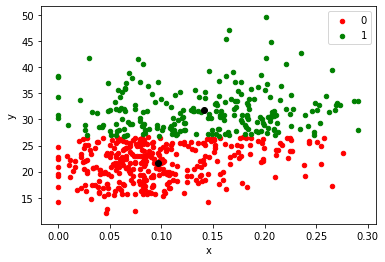

In [161]:
centroids = get_centroids(subset_df, 'clusters')
plot_clusters(subset_df, 'clusters', centroids)

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [164]:
# This is mess i know... sorry
work_check = subset_df

# Add the diagnosis column
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
work_check['diagnosis'] = df['diagnosis']

# Check the new dataframe
work_check.head()

# create new dataframe to work with
accuracy_df = pd.DataFrame({'diagnosis': work_check['diagnosis'], 'clusters': work_check['clusters']})
accuracy_df.head()

,diagnosis,clusters
0,M,0
1,M,0
2,M,0
3,M,0
4,M,0


In [165]:
accuracy_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [166]:
accuracy_df['diagnosis'] = accuracy_df['diagnosis'].replace({"B": 0, "M": 1})

accuracy_df

,diagnosis,clusters
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
564,1,0
565,1,1
566,1,1
567,1,1


In [168]:
# Accuracy
(accuracy_df['diagnosis'] == accuracy_df['clusters']).value_counts()[1]/len(accuracy_df)

0.718804920913884

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [173]:
df = df.drop('diagnosis', axis=1)
df = df.drop('Unnamed: 32', axis=1)
df = df.drop('id', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [175]:
scaler = StandardScaler()
# Use StandardScaler
Z = scaler.fit_transform(df)

Z[0]

array([ 1.09706398, -2.07333501,  1.26993369,  0.9843749 ,  1.56846633,
        3.28351467,  2.65287398,  2.53247522,  2.21751501,  2.25574689,
        2.48973393, -0.56526506,  2.83303087,  2.48757756, -0.21400165,
        1.31686157,  0.72402616,  0.66081994,  1.14875667,  0.90708308,
        1.88668963, -1.35929347,  2.30360062,  2.00123749,  1.30768627,
        2.61666502,  2.10952635,  2.29607613,  2.75062224,  1.93701461])

In [178]:
pca = PCA(.9)
transformed_data = pca.fit_transform(Z)
transformed_data

array([[ 9.19283683,  1.94858307, -1.12316616, ..., -1.19511012,
         1.41142445,  2.15936987],
       [ 2.3878018 , -3.76817174, -0.52929269, ...,  0.62177498,
         0.02865635,  0.01335809],
       [ 5.73389628, -1.0751738 , -0.55174759, ..., -0.1770859 ,
         0.54145215, -0.66816648],
       ...,
       [ 1.25617928, -1.90229671,  0.56273053, ...,  1.80999133,
        -0.53444719, -0.19275823],
       [10.37479406,  1.67201011, -1.87702933, ..., -0.03374193,
         0.56793647,  0.22308167],
       [-5.4752433 , -0.67063679,  1.49044308, ..., -0.18470331,
         1.61783736,  1.69895156]])

In [180]:
len(transformed_data.T)

7

In [181]:
pca.explained_variance_ratio_.sum()

0.9100953006967308

In [0]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

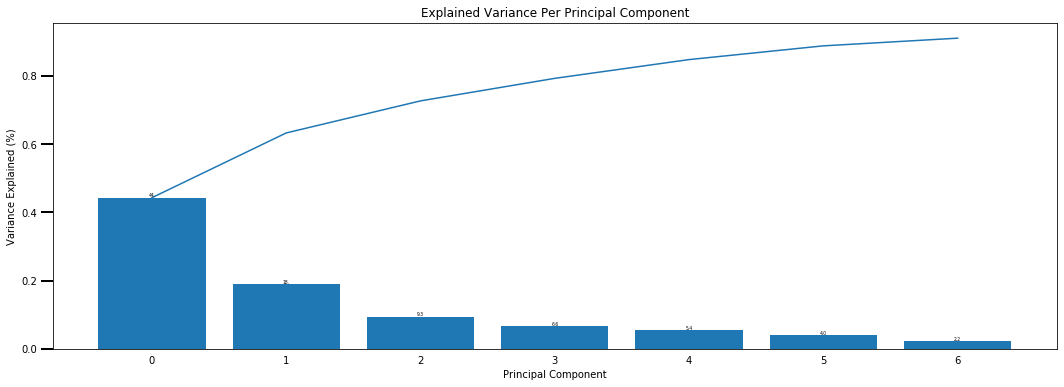

In [183]:
scree_plot(pca)

In [185]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(transformed_data)
print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

In [187]:
accuracy_df = pd.DataFrame({'diagnosis': accuracy_df['diagnosis'], 'label': kmeans.labels_})

accuracy_df.head()

,diagnosis,label
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [189]:
(accuracy_df['diagnosis'] == accuracy_df['label']).value_counts()[1]/len(accuracy_df)

0.08963093145869948

In [191]:
"""
The original K-means test resulted in a 0.718804920913884 successful predictor rate for diagnosis.
When K-means was applied after PCA, the successful prediction rate was 0.9103690685413005

An improvement in our clustering algorithm as a predictor by nearly 20%
"""
1 - .08963093145869948

0.9103690685413005

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project